<h1 style='text-align: center; font-size: 38px; font-weight: bold; color: #5a189a;'> Spam Classification </h1>
<p style='text-align: center; color: #212121;'> This is a special notebook. I'll be exploring another classification problem in NLP but in this time, I'll be also commenting everything I'm doing - with hope to be helpful for someone in the future. This exercise will also be important for me to organize my thoughts, put in practice what I've learnt and also retain knowledge more easily. </p>

<h3 style='color: #7b2cbf; text-align: center;'> Setting Up </h3>

<p style='text-align: justify; color: #212121; font-size: 16px;'> First of all, I'm going to verify the GPU status for this machine. You can see that I also install some libraries that I might use in the future. </p>

In [1]:
%pip install chardet plotly loguru demoji --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA device: {torch.cuda.get_device_name(device)}")
    print(f"Device capability: {torch.cuda.get_device_capability(device)}")
    print(f"Total memory: {torch.cuda.get_device_properties(device).total_memory / 1024**3:.2f} GB")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
else:
    print("CUDA is not available on this device.")

Using CUDA device: NVIDIA RTX A6000
Device capability: (8, 6)
Total memory: 47.54 GB
Number of CUDA devices: 1


<p style='text-align: justify; color: #212121; font-size: 16px;'> Now I'll be importing the required libraries so I can get everything set up. In addition, I'll be verifying the encoding for my data file so I can import it using Pandas in a better way. </p>

In [3]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords as stpw
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import torch.nn.functional as F
import matplotlib.pyplot as plt
from loguru import logger
import torch.nn as nn
import pandas as pd
import numpy as np
import chardet
import string
import demoji
import torch
import tqdm
import nltk

nltk.download(['punkt', 'wordnet', 'stopwords', 'omw-1.4'], download_dir='data/nltk_downloads', quiet=True)

%matplotlib inline

nltk.data.path.append('data/nltk_downloads/')

with open('data/email_spam.csv', 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']

df = pd.read_csv('data/email_spam.csv', encoding=encoding)

if len(df) != 0:
  logger.success('Dataset loaded successfully with {} rows'.format(len(df)))
else:
  logger.error('Dataset not loaded')

2023-08-18 21:02:54.638 | SUCCESS  | __main__:<module>:32 - Dataset loaded successfully with 5572 rows


<p style='text-align: justify; color: #212121; font-size: 16px;'> I might be a perfectionist, but I'll make some modifications regarding the label column names. </p>

In [4]:
print(f'Previous columns: {df.columns.tolist()}')
df.columns = list(['label', 'text'])
print(f'New columns: {df.columns.tolist()}')
df['label'] = df.label.map({'ham': 'not spam', 'spam': 'spam'})
df = df[['text', 'label']]
df.head()

Previous columns: ['Category', 'Message']
New columns: ['label', 'text']


,text,label
0,"Go until jurong point, crazy.. Available only ...",not spam
1,Ok lar... Joking wif u oni...,not spam
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,not spam
4,"Nah I don't think he goes to usf, he lives aro...",not spam


<h3 style='color: #7b2cbf; text-align: center;'> Quick EDA </h3>

<p style='text-align: justify; color: #212121; font-size: 16px;'> Now I want to start a quick process that I call <bold>Quick EDA<bold> - which consists in a short EDA where I can see some overall tips on how my data is behaving or what type of problem am I dealing. Some useful questions we might come up with are as follows: </p>

<ul>
  <li><p style='text-align: justify; color: #212121; font-size: 16px;'>Is this an imbalenced or balanced problem?</p></li>
  <li><p style='text-align: justify; color: #212121; font-size: 16px;'>Are there any null values? If yes, then how many?</p></li>
  <li><p style='text-align: justify; color: #212121; font-size: 16px;'>Are there any duplicates? If yes, how many? Could it compromise our model?</p></li>
  <li><p style='text-align: justify; color: #212121; font-size: 16px;'>How are the tokens approximately behaving?</p></li>
</ul>

In [5]:
text, label = df.isna().sum()
logger.info(f'There are {text} empty texts and {label} empty labels in the dataset.')

2023-08-18 21:02:58.290 | INFO     | __main__:<module>:2 - There are 0 empty texts and 0 empty labels in the dataset.


In [6]:
duplicates = df[df.duplicated()]
logger.info(f'There are {len(duplicates)} duplicates in the dataset.')
logger.info(f'The percentage is {len(duplicates)/len(df)*100:.2f}%. So we can drop them.')
df = df.drop_duplicates()

2023-08-18 21:02:58.501 | INFO     | __main__:<module>:2 - There are 415 duplicates in the dataset.
2023-08-18 21:02:58.502 | INFO     | __main__:<module>:3 - The percentage is 7.45%. So we can drop them.


2023-08-18 21:02:58.662 | INFO     | __main__:<module>:9 - The dataset is imbalanced.


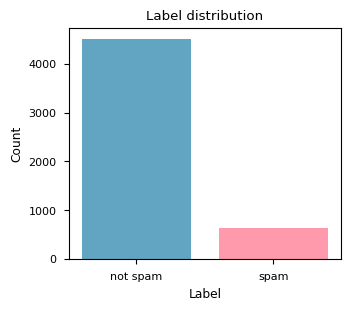

In [7]:
aux = pd.DataFrame(df.label.value_counts()).reset_index().rename(columns={'index':'label','label':'count'})

try:
  if np.sum(aux['count'].tolist()) == df.shape[0]:
    spam = aux.query('label == \'spam\'').sum()[1] / df.shape[0]
    not_spam = aux.query('label == \'not spam\'').sum()[1] / df.shape[0]
    
    if spam * 5 > not_spam * 5 or not_spam * 5 > spam * 5:
      logger.info('The dataset is imbalanced.')
    
  else:
    raise Exception
except:
  logger.error('The sum of the count column is not equal to the number of rows in the dataframe.')

plt.figure(figsize=(3.5, 3))
plt.style.use('seaborn-v0_8-paper')

plt.bar(aux.label, aux['count'], color=['#61a5c2', '#ff99ac'])
plt.title('Label distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

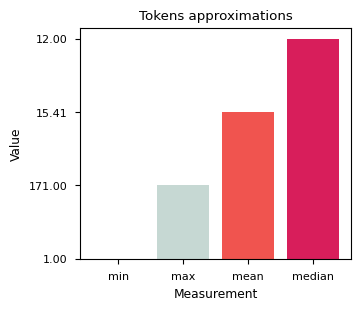

In [8]:
def token_approximation(text: str) -> int:
  return len(str.split(text))

ta = dict({
  'min': f'{np.min([token_approximation(text) for text in df.text.tolist()]):.2f}',
  'max': f'{np.max([token_approximation(text) for text in df.text.tolist()]):.2f}',
  'mean': f'{np.mean([token_approximation(text) for text in df.text.tolist()]):.2f}',
  'median': f'{np.median([token_approximation(text) for text in df.text.tolist()]):.2f}'
})

token_approximations = pd.DataFrame(list(ta.items()), columns=['measurement', 'value'])

plt.figure(figsize=(3.5, 3))
plt.style.use('seaborn-v0_8-paper')

plt.bar(token_approximations.measurement, token_approximations.value, color=['#fdf0d5', '#c6d8d3', '#f0544f', '#d81e5b'])
plt.title('Tokens approximations')
plt.xlabel('Measurement')
plt.ylabel('Value')
plt.show()

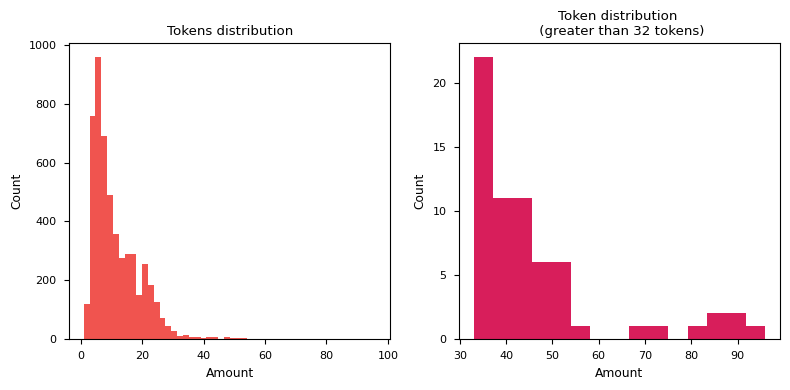

In [208]:
aux = df.copy(deep=True)
aux['tl'] = aux.tokens.apply(lambda x: len(x))
aux = aux.tl.tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.hist(aux, bins=50, color='#f0544f')
ax1.set_title('Tokens distribution')
ax1.set_xlabel('Amount')
ax1.set_ylabel('Count')

aux2 = df.copy(deep=True)
aux2['tl'] = aux2.tokens.apply(lambda x: len(x))
aux2 = aux2.query('tl > 32')
aux2 = aux2.tl.tolist()

ax2.hist(aux2, bins=15, color='#d81e5b')
ax2.set_title('Token distribution \n (greater than 32 tokens)')
ax2.set_xlabel('Amount')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

<h3 style='color: #7b2cbf; text-align: center;'> Preprocessing </h3>

<p style='text-align: justify; color: #212121; font-size: 16px;'> Alright, now we're ready to start preprocessing our data. I'll be removing stopwords, punctuations and applying a lemmatization technique. I'll be also label encoding our targets and getting the vectors/tensors from our texts. </p>

<blockquote>
  <p style='text-align: justify; color: #212121; font-size: 16px;'>I know that this dataset might not have any emoji, but I want to implement a way to translate them into text, if present.</p>
  <ul>
    <li>
      <p style='text-align: justify; color: #212121; font-size: 16px;'>In this case, the emoji 💜 becomes <i>purple_heart</i>. </p>
    </li>
    <br>
  </ul>
</blockquote>

In [209]:
stopwords = set(stpw.words('english'))
punctuations = set(string.punctuation)

def preprocessing(text: str, stopwords: set, punctuation: set) -> tuple[list[str], str]:
    emojis = demoji.findall(text)
    
    new_text = ''
    for i, character in enumerate(text):
        if character in emojis.keys():
            translation = str.join('_', emojis[character].split())
            new_text += translation
        else:
            new_text += character
        
    lemmatizer = WordNetLemmatizer()
    
    tokens = word_tokenize(new_text)
    lemmas = [ lemmatizer.lemmatize(token) for token in tokens ]
    
    tokens = [ str.lower(token) for token in lemmas if token not in stopwords and token not in punctuations ]
    refined_text = ' '.join(tokens)
    
    if len(tokens) == 0:
        return ['EMPTY'], 'EMPTY'
    else:
        return tokens, refined_text
    
df['tokens'], df['refined_text'] = zip(*df['text'].apply(lambda x: preprocessing(x, stopwords, punctuations)))

logger.info('The dataset has been preprocessed. It has a shape of {} now.'.format(df.shape))

2023-08-18 21:47:25.693 | INFO     | __main__:<module>:30 - The dataset has been preprocessed. It has a shape of (5157, 4) now.


<p style='text-align: justify; color: #212121; font-size: 16px;'> In this point, I'll create my vocabulary and also be creating two special ids in order to handle unknown tokens and fit all the outputs in the same padding size. I'll be defining two other functions to handle attention_mask and decoding the ids as well. </p>

In [210]:
vocab = list()
for tokens in df.tokens:
    vocab.extend(tokens)

vocab = set(vocab)
vocab = dict(zip(vocab, range(2, len(vocab) + 2)))
vocab['UNK'] = 1
vocab['PAD'] = 0
vocab = dict(sorted(vocab.items(), key=lambda item: item[1]))

In [350]:
def get_ids(text: str, max_length: int) -> np.ndarray[int]:
  text = str.lower(text)
  vector = [vocab[word] if word in vocab.keys() else vocab['UNK'] for word in text.split()]
  vector = vector[:max_length] + [vocab['PAD']] * (max_length - len(vector))
  return np.array(vector)

def get_attention_mask(ids: np.ndarray[int]) -> np.ndarray[int]:
  return np.array([1 if id > 0 else 0 for id in ids])

def ids_decoder(ids: np.ndarray[int], vocab: dict[str, int]) -> str:
  reconstruction = list(vocab.keys())[list(vocab.values()).index(mysterious_data[0])]
  for i in mysterious_data[1:]:
      word = list(vocab.keys())[list(vocab.values()).index(i)]
      word = ' ' + word if word != 'PAD' else ''
      reconstruction += word
      
  return reconstruction

max_length = 64
sample_text = df.sample(1, random_state=20).refined_text.values[0]
input_ids = get_ids(sample_text, max_length)
attention_mask = get_attention_mask(input_ids)

input_ids, attention_mask

(array([6307, 6253,   55, 5307,  369,   55, 4735, 5135, 2072,   55, 2875,
           9, 7883,   55,  426, 6253,   55, 6818,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))